# Connect to Google drive (optional)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Sat May 31 03:41:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install depedencies

In [2]:
# %pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1
# if use GPU
%pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
%pip install -q accelerate transformers ninja
%pip install xformers==0.0.29 --index-url https://download.pytorch.org/whl/cu124
%pip install -q git+https://github.com/huggingface/diffusers.git
%pip install -q opencv-contrib-python
%pip install -q controlnet_aux

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 124.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/2

In [3]:
from diffusers import StableDiffusionPipeline, DDIMScheduler, StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler, DEISMultistepScheduler
from PIL import Image
from controlnet_aux import OpenposeDetector
import torch
import cv2
import numpy as np
from torch import autocast
from IPython.display import display

/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segmen

# Generate image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

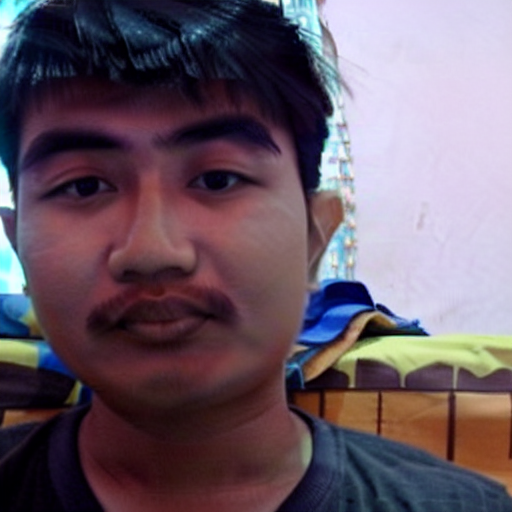

In [6]:
prompt = "a photo of sks_raffel at the beach"  # @param {type:"string"}
negative_prompt = "indoor, bedroom, same background"  # @param {type:"string"}

model_path = "/content/gdrive/MyDrive/stable diffusion/model_2"

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to('cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.safety_checker = lambda images, clip_input: (images, [False] * len(images))

seed = 555
num_samples = 3
guidance_scale = 7.5
num_inference_steps = 30
height = 512
width = 512

generator = torch.Generator(device='cuda').manual_seed(seed)

with autocast("cuda"), torch.inference_mode():
    imgs = pipe(
        prompt,
        negative_prompt=negative_prompt,
        height=height, width=width,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    ).images

for img in imgs:
    display(img)

Look like my stable diffusion is overfitting XD, If you experience the same thing, then the training data must be varied (currently my data is not varied, just a photo of myself and with the same background).

# Generate image with controlnet

## ControlNet with Canny Edge

### Initialize canny edge model

In [7]:
controlnet_canny_model = 'lllyasviel/sd-controlnet-canny'
control_net_canny = ControlNetModel.from_pretrained(controlnet_canny_model, torch_dtype=torch.float16)

pipe = StableDiffusionControlNetPipeline.from_pretrained('runwayml/stable-diffusion-v1-5',
                                                         controlnet=control_net_canny,
                                                         torch_dtype=torch.float16)

img = Image.open('/content/gdrive/MyDrive/stable diffusion/test_image/lion.jpg')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Our test image look like this

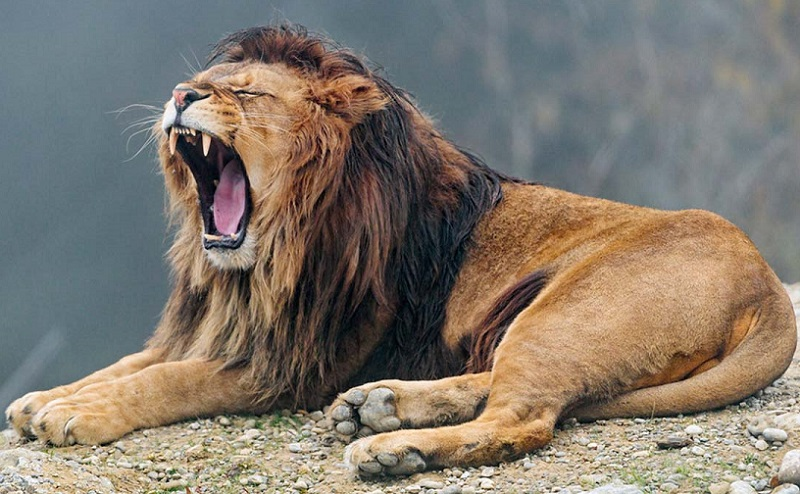

In [8]:
img

###Get the canny edge from the image

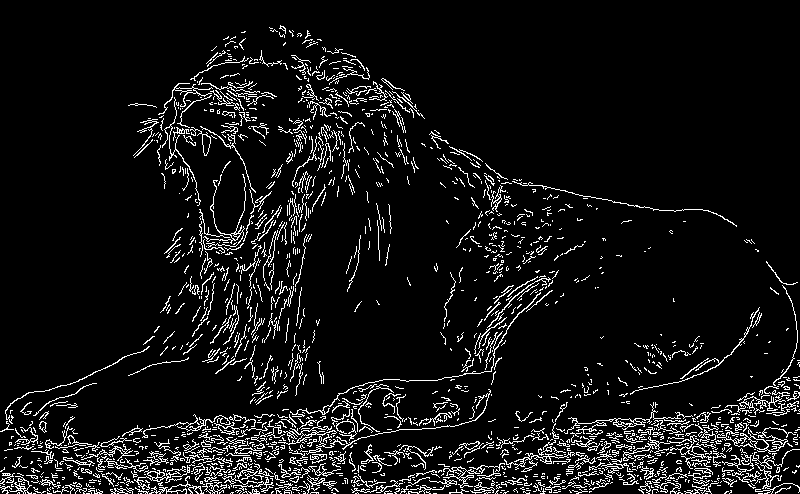

In [9]:
def canny_edge(img, low_threshold = 200, high_threshold = 300):
  img = np.array(img)

  img = cv2.Canny(img, low_threshold, high_threshold)

  img = img[:, :, None]

  img = np.concatenate([img, img, img], axis = 2)

  canny_img = Image.fromarray(img)

  return canny_img

canny_img = canny_edge(img)
canny_img

### Generate image

In [10]:
prompt = "blue lion" # @param {type:"string"}
neg_prompt = "female lion" # @param {type:"string"}

generator = torch.Generator(device="cuda").manual_seed(seed)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

imgs = pipe(
    prompt,
    canny_img,
    negative_prompt=neg_prompt,
    generator=generator,
    num_inference_steps=20,
)

  0%|          | 0/20 [00:00<?, ?it/s]

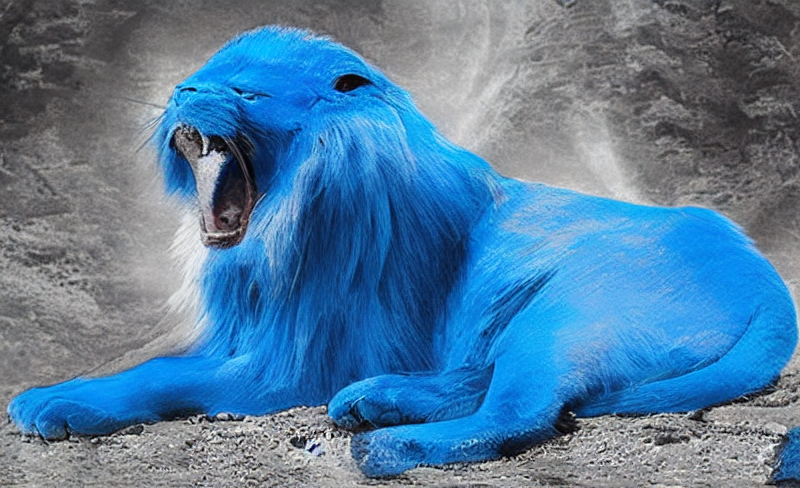

In [11]:
# image result
imgs.images[0]

# if you want save it, uncomment below code
# for i, img in enumerate(imgs.images):
#   img.save('canny-edge-results/result_{}.png'.format(i+1))

## ControlNet to Generate Image Using Pose

In [17]:
pose_model = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
img_pose = Image.open('/content/gdrive/MyDrive/stable diffusion/test_image/lionel-messi.jpg')
pose = pose_model(img_pose)

controlnet_pose_model = ControlNetModel.from_pretrained(
    'lllyasviel/sd-controlnet-openpose', torch_dtype=torch.float16
)

sd_controlpose = StableDiffusionControlNetPipeline.from_pretrained('/content/gdrive/MyDrive/stable diffusion/model_2',
                                                                   controlnet=controlnet_pose_model,
                                                                   torch_dtype=torch.float16)


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

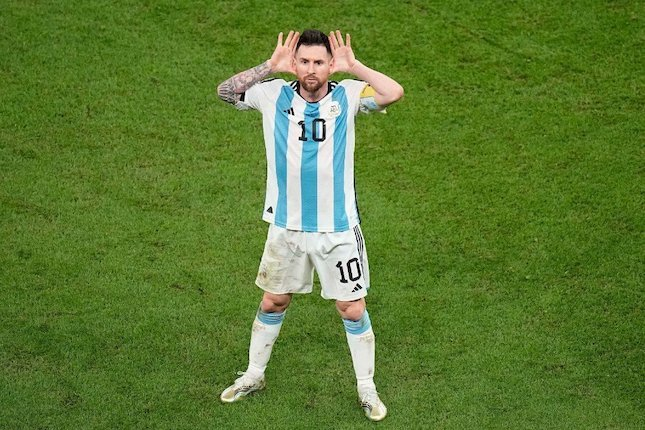

In [21]:
img_pose

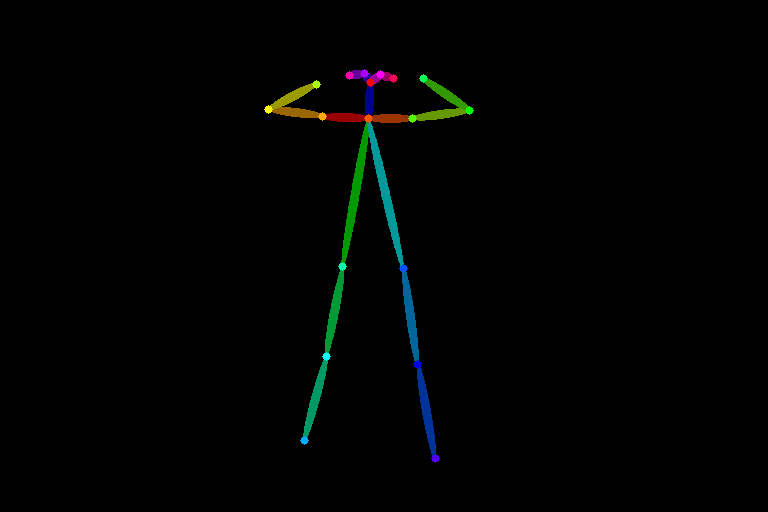

In [18]:
pose

In [19]:
prompt = "sks_Raffel, barcelona jersey" # @param {type:"string"}
neg_prompt = "" # @param {type:"string"}

seed = 100

generator = torch.Generator(device="cuda").manual_seed(seed)

sd_controlpose.enable_model_cpu_offload()
sd_controlpose.enable_attention_slicing()
sd_controlpose.enable_xformers_memory_efficient_attention()
sd_controlpose.scheduler = DEISMultistepScheduler.from_config(sd_controlpose.scheduler.config)

imgs_2 = sd_controlpose(
    prompt,
    pose,
    negative_prompt=neg_prompt,
    num_images_per_prompt=1,
    generator=generator,
    num_inference_steps=20,
)

  0%|          | 0/20 [00:00<?, ?it/s]

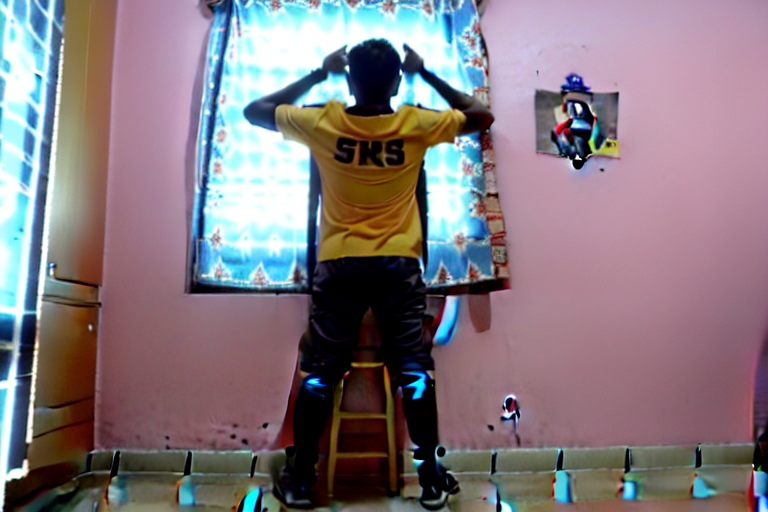

In [20]:
# image result
imgs_2.images[0]

# if you want save it, uncomment below code
# for i, img in enumerate(imgs_2.images):
#   img.save('canny-edge-results/result_{}.png'.format(i+1))